----

## Descripción del proyecto

Vamos a realizar un modelo que permita analizar el comportamiento de los clientes de la compañía móvil Megaline, esto para resolver la siguiente problemática:

Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados, por lo tanto el modelo nos permitirá recomendar uno de los nuevos planes (Smart o Ultra) a sus clientes.

Contamos con los datos de comportamiento de los sucriptores que ya se han cambiado a los nuevos planes.

Desarrollaremos un modelo de clasificación que elija el plan correcto, este modelo contará con la mayor exactitud posible (Umbral de *exactitud* de 0.75)

## Importando Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error



## Cargando dataset

In [2]:
mega = pd.read_csv('/datasets/users_behavior.csv')

### Explorando dataset

In [3]:
print(mega.info())
print(mega.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000  

In [4]:
mega.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


* **Los datos, al ya venir pre-tratados desde el proyecto de Análisis estadístico de datos, están listos para ser utilizados, sin embargo vamos a explorarlos**

* La columna 'calls' nos muestra la cantidad de llamadas realizadas en el periodo
* La columna 'minutes' nos muestra en minutos la duración de las llamadas
* La columna 'messages nos muestra la cantidad de mensajes enviados en el epriodo
* La columna 'mb_used' muestra en MB la cantidad de Megabytes utilizados en el periodo
* La columna 'is_ultra' muestra en booleano (0 para falso, 1 para verdadero) si el plan que tiene el usuario es ultra o no

Todas las columnas, excepto 'is_ultra' tienen tipo de variable float64, lo cual es correcto, la columna 'is_ultra' cuenta con el tipo de variable int64, la cual es funcional para un booleano y para las regresiones de clasificación que vamos a realizar



## Segmentando los datos en un conjunto de entrenamiento, uno de validación y uno de prueba.

In [5]:
# Segmentando los conjuntos de datos (Entrenamiento ,validación y pruebas)
full_train_df , test_df = train_test_split(mega, test_size=0.18, random_state = 88)
train_df, valid_df  = train_test_split(full_train_df, test_size= .23 , random_state = 88)


In [6]:
#Verificando las porciones de la segmentación en relación al dataframe original (mega)
print([ len(df) for df in [mega, full_train_df, train_df, valid_df, test_df]])

[round( len(df)/(len(mega)) ,3 ) for df in [mega, full_train_df, train_df, valid_df, test_df]]

[3214, 2635, 2028, 607, 579]


[1.0, 0.82, 0.631, 0.189, 0.18]

Decidimos que vamos a utilizar una segmentación de la siguiente manera:
* 82% de los datos para el conjunto completo de entrenamiento
* 63% de los datos para el conjunto de entrenamiento
* 18.9% de los datos para el conjunto de validación
* 18% de los datos para el conjunto de prueba

## Definiendo el los objetivos y características (Target y Features)

In [8]:
#Definiendo features y target

target = 'is_ultra'
features = [i for i in mega.columns if i not in [target]]
print(target)
print(features)

is_ultra
['calls', 'minutes', 'messages', 'mb_used']


In [9]:
#Definiendo los features y target para el conjunto de entrenamiento
features_train=train_df[features]
target_train = train_df[target]

#Definiendo los features y target para el conjunto de validación
features_valid = valid_df[features]
target_valid = valid_df[target]

In [10]:
#Calculando el promedio del target
print(f'La cantidad promedio de usuarios que tienen plan ultra es del: {round(mega[target].mean()*100,2)}% del total ', )
print(f'La cantidad promedio de usuarios que tienen plan Smart es del: {round((1-mega[target].mean())*100,2)}% del total ', )

La cantidad promedio de usuarios que tienen plan ultra es del: 30.65% del total 
La cantidad promedio de usuarios que tienen plan Smart es del: 69.35% del total 


## Explorando visualmente el dataset

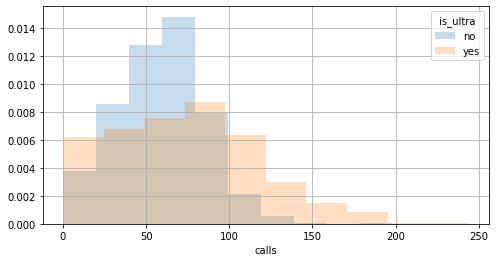

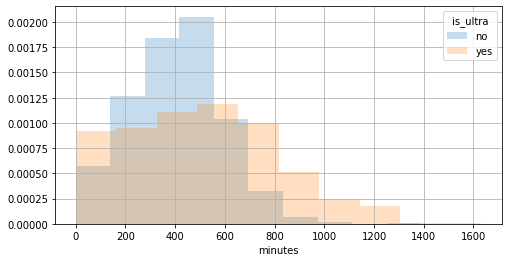

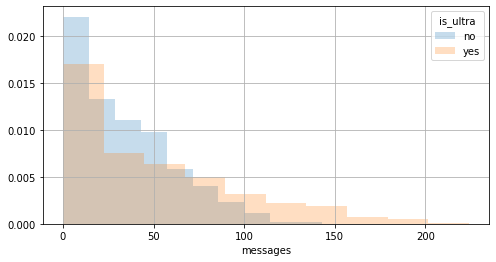

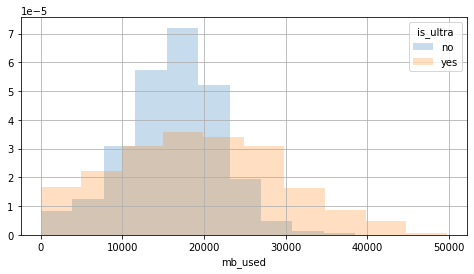

In [11]:
#Explorando mediante histogramas las distribuciones de los datos
for feature in features:

    plt.figure(figsize=(8, 4))
    mega.query("is_ultra == 0")[feature].hist(label="no", alpha=0.25, ax=plt.gca(), density=True)
    mega.query("is_ultra == 1")[feature].hist(label="yes", alpha=0.25, ax=plt.gca(), density=True)
    plt.legend(title="is_ultra")
    plt.xlabel(feature)
    plt.show()

En esta primera exploración podemos observar:
* A mayor cantidad de llamadas, se observa una mayor probabilidad de que el usuario sea de plan Ultra
* A mayor cantidad de minutos, se observa una mayor probabilidad de que el usuario sea de plan Ultra
* En los mensajes, los planes Ultra y Smart se comportan similar, sin embargo se observa una ligeratendencia a que los usuarios de plan Ultra envíen mayor cantidad de mensajes
* Respecto a la cantidad de MB utilizados por los usuarios, se observa una media cercana a los 18,000 Mb, sin embargo se observa mayor presencia de planes Ultra a medida que pasan los 25,000 MB utilizados.

## Explorando los diferentes modelos

### Árbol de decisión de clasificación

In [12]:
best_model = None
best_score = -100
best_depth = 0



#Loop que recorre los niveles de profundidad del arbol del 1 al 6
for depth in range (1,6):
    #Creamos una instancia de DecisionTreeClassifire con un random_state y una profundidad máxima = depth
    model= DecisionTreeClassifier(max_depth=depth, random_state=88)
    
    #Entrenamos el modelo con los features y target de entrenamiento
    model.fit(features_train, target_train)
    
    #Realizamos las predicciones del modelo en el conjunto de validación
    predictions_valid_tree = model.predict(features_valid)
    #Calculamos le puntuación de exactitud
    score = accuracy_score(target_valid, predictions_valid_tree)
    # Evaluamos el mejor score de todos los niveles de profundidad
    if score > best_score:
        best_model = model
        best_score = score
        best_depth = depth
        
#Imprimimos el mejor modelo y sus características
print(f"Accuracy Score del mejor modelo en el conjunto de validación (max_depth = {best_depth}): {best_score}")




Accuracy Score del mejor modelo en el conjunto de validación (max_depth = 2): 0.8105436573311368


* **Observamos que tenemos un Accuracy Score de 0.81 con una profundidad = 2 , lo cual supera el umbral de 0.75 establecido en el problema, veamos los demás modelos para evaluar su comportamiento**


### Bosque aleatorio de clasificación

In [13]:
#Probando con Random Forest Classifier
best_score = -1000


for n_est in [50,100,150,200]:
    for depth in [5,10,15]:
        model_forest = RandomForestClassifier(n_estimators = n_est, max_depth = depth, random_state=888)

        model_forest.fit(train_df[features],train_df[target] )
        y_preds = model_forest.predict(valid_df[features])

        score = accuracy_score(valid_df[target],y_preds)
        
        if score > best_score:
            best_score = score
            best_depth=depth
            print(f"""
            N estimators : {n_est}
            Max depth: {depth}
            Accuracy : {score}
            """)

            
print (f'Accuracy del mejor modelo de validación best_score = {best_score}, n_estimators = {n_est}, best_depth : {best_depth}')



            N estimators : 50
            Max depth: 5
            Accuracy : 0.8105436573311368
            

            N estimators : 50
            Max depth: 10
            Accuracy : 0.828665568369028
            

            N estimators : 150
            Max depth: 10
            Accuracy : 0.8352553542009885
            
Accuracy del mejor modelo de validación best_score = 0.8352553542009885, n_estimators = 200, best_depth : 10


* **Observamos que con un Bosque aleatorio de clasificación, obtenemos un Accuracy score = 0.835 con un número de estimadores = 200 y una profundidad de 10 niveles, el cual supera el umbral de exactitud de 0.75 establecido en el problema, veamos el último modelo y evaluemos su comportamiento**

### Regresión Logística

In [14]:
#Inicializando el constructor del modelo
model_linear = LogisticRegression(random_state=88, solver='liblinear')

# Entrenando el modelo con el conjunto de entrenamiento
model_linear.fit(features_train, target_train)

# Obteniendo predicciones para el modelo con el conjunto de validación
predictions_linear = model_linear.predict(features_valid)

# Calculando el Accuracy Score
accuracy_score(predictions_linear, target_valid)

0.729818780889621

* **Con la regresión logística obtuvimos un Accuracy Score de 0.729, el cual se encuentra por debajo de el umbral de 0.75 establecido en el problema**

### Conclusiones
**Observamos los siguientes resultados:**

* **Para el Árbol de decisión de clasificación tenemos un Accuracy Score de 0.81 con una profundidad = 2 , lo cual supera el umbral de 0.75 establecido en el problema.**

* **Para el Bosque aleatorio de clasificación, obtenemos un Accuracy score = 0.835 con un número de estimadores = 200 y una profundidad de 10 niveles, el cual supera el umbral de exactitud de 0.75 establecido en el problema.**

* **Para la Regresión logística obtuvimos un Accuracy Score de 0.729, el cual se encuentra por debajo de el umbral de 0.75 establecido en el problema.**


Con esto concluimos que el mejor modelo de clasificación para este problema fue el **Bosque Aleatorio de clasificación** con una exactitud de 0.835, un número de estimadores = 200 y una profundidad de 10 niveles.

Con esto en mente, ahora trabajemos este modelo con el conjunto de datos de prueba para resolver el problema planteado


## Evaluando el conjunto de prueba con el mejor modelo (Random Forest Clasification) 

In [15]:
#Creando una instancia del modelo RandomForestClassifier
final_model = RandomForestClassifier(n_estimators = 150, max_depth=10,random_state=88)

#Entrenando el modelo con el conjunto (completo) de entrenamiento
final_model.fit(full_train_df[features], full_train_df[target])
# Realizando las predicciones con el conjunto de prueba
test_preds= final_model.predict(test_df[features])

final_score = accuracy_score(test_df[target],test_preds)
print (f'Accuracy del modelo final:  score = {final_score}, n_estimators = {150}, depth : {10}')

Accuracy del modelo final:  score = 0.8065630397236615, n_estimators = 150, depth : 10


### Conclusiones de resultados del mejor modelo

Observamos que al entrenar el modelo con el conjunto completo de entrenamiento (82% del total de los datos) y realizar las predicciones al conjunto de prueba (18% del total de los datos) el accuracy score se reduce ligeramente (sobreajuste), pasando de un 0.835 a un 0.806 , esto puede ser por que el volumen de datos con el que trabaja el nuevo modelo se vio incrementado, sin embargo, a pesar de este ligero sobreajuste sigue cumpliendo con el umbral de exactitud mayor a 0.75


## Prueba de fidelidad

Vamos a comparar las predicciones con la posibilidad aleatoria, para esto vamos a darle la misma respuesta (1) a todas las observaciones y calcular su exactitud (accuracy score)

In [16]:
accuracy_score(test_df[target], pd.Series([1] * len(test_df)))

0.3298791018998273

In [17]:
#Predicción 
1-accuracy_score(test_df[target], pd.Series([1] * len(test_df)))

0.6701208981001727

Podemos observar que el porcentaje de observaciones con valor (1) es de un 32.9%, en cambio el porcentaje de observaciones con valor (0) es de 67%.

Ahora vamos a comparar el accuracy score cuando tomamos una predicción aleatoria

In [18]:
#Predicción aleatoria
accuracy_score(test_df[target] , np.random.choice([0,1], len(test_df)))

0.5181347150259067

Podemos observar que al tomar una predicción aleatoria, tenemos un accuracy de 0.49, lo que significa que cuando se tiene una predicción aleatoria, tenemos un 49% de que el valor sea (1)

## Conclusiones

Pudimos realizar el entrenamiento de un modelo de regresión clasificatoria para predecir que plan debería ser recomendado para los usuarios conforme a su comportamiento en el consumo de llamadas, mensajes, datos móviles y minutos consumidos.

Se elige el modelo de **Bosque aleatorio de clasificación** como el mejor modelo debido a que nos ofrece una calificación de exactitud de 0.806, la cual supera el umbral definido de 0.75 .

Se realizaron pruebas de fidelidad con predicciones de posibilidad aleatoria a través del Accuracy Score.

Será emocionante poner a prueba el modelo para realizar predicciones con nuevos datos
